# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
label = "nPN"
nmax = 4

In [2]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

In [3]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [4]:
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")
print(traindata.shape, testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(640341, 6) (159659, 6)


In [5]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(
        x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2
    )
    print("----")

(SM)
Epoch 1/50
641/641 - 1s - loss: 59.3476 - accuracy: 0.2645 - val_loss: 11.6814 - val_accuracy: 0.2751
Epoch 2/50
641/641 - 1s - loss: 3.1056 - accuracy: 0.3253 - val_loss: 1.8576 - val_accuracy: 0.3476
Epoch 3/50
641/641 - 2s - loss: 1.4938 - accuracy: 0.3681 - val_loss: 1.2083 - val_accuracy: 0.4014
Epoch 4/50
641/641 - 1s - loss: 1.0766 - accuracy: 0.4697 - val_loss: 0.9999 - val_accuracy: 0.5454
Epoch 5/50
641/641 - 1s - loss: 0.9702 - accuracy: 0.5852 - val_loss: 0.9443 - val_accuracy: 0.6049
Epoch 6/50
641/641 - 1s - loss: 0.9278 - accuracy: 0.6283 - val_loss: 0.9078 - val_accuracy: 0.6351
Epoch 7/50
641/641 - 1s - loss: 0.8924 - accuracy: 0.6453 - val_loss: 0.8730 - val_accuracy: 0.6337
Epoch 8/50
641/641 - 1s - loss: 0.8604 - accuracy: 0.6589 - val_loss: 0.8427 - val_accuracy: 0.6481
Epoch 9/50
641/641 - 1s - loss: 0.8330 - accuracy: 0.6674 - val_loss: 0.8159 - val_accuracy: 0.6612
Epoch 10/50
641/641 - 1s - loss: 0.8094 - accuracy: 0.6734 - val_loss: 0.7943 - val_accuracy:

In [7]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

for name, model in models.items():
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(name, bac)

(SM) 0.7646230439098949
(10, SM) 0.7583200793472819
(20, SM) 0.7669819175390524
(100, SM) 0.772962881527379
(100, 10, SM) 0.7766959474321616


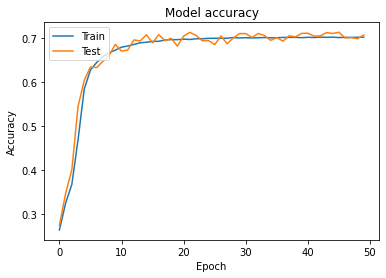

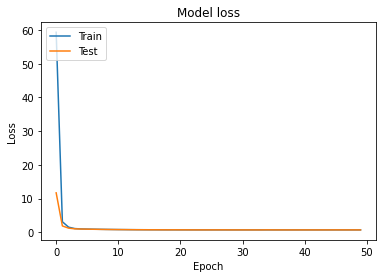

In [8]:
history = histories["(SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [9]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

y_pred = models["(20, SM)"].predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print(cmrel)

0.7669819175390524
[[ 2059     0     0     0     0]
 [    0 36274  1579     7    11]
 [    0  8024 26608  5189    31]
 [    0  1052  8991 16794 12848]
 [    0   117  1820  6655 31600]]
[[1.    0.    0.    0.    0.   ]
 [0.    0.958 0.042 0.    0.   ]
 [0.    0.201 0.668 0.13  0.001]
 [0.    0.027 0.227 0.423 0.324]
 [0.    0.003 0.045 0.166 0.786]]
